IMPORTANT: submissions in test set should be different from train set, i.e., `train_test_different_submissions = True`

In [1]:
CONFIG_PATH = "configs/subreddit_minority_no_peer_test_diff.yml"
from utils import get_config
config = get_config(CONFIG_PATH, "_curation", print_config = False)
peer_vote_option = "real" # "real", "real_user_same_vote", "similar_user_same_vote", "real_user_opposite_vote", "similar_user_opposite_vote"
from superdebug import debug
debug(peer_vote_option=peer_vote_option)
use_voted_users_feature = config["use_voted_users_feature"]
use_voted_users_feature = False
if use_voted_users_feature:
    print("Use peer votes as model input feature")
else:
    print("Finetune the model using peer votes")

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-09-03 05:52:55 ------------------
GPU ready...
Smart using cuda:2
------------------ 2022-09-03 05:52:56 ------------------
DEBUG: 1 vars: ['peer_vote_option'], at <ipython-input-1-81dd585ce79b>:6 <module>
0 / 1.  peer_vote_option str len 4: real
------------------ 2022-09-03 05:52:56 ------------------
Finetune the model using peer votes


In [2]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
import torch
from process_data import get_model_input
from model import get_best_model, TransformerVoter
from utils import get_user_reps, get_bool_vec, record_existing_votes
from train import evaluate_model, train_model
import sklearn.metrics
import copy

Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


In [3]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)

------------------ 2022-09-03 05:53:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:363 get_model_input
Loading prepared data...
------------------ 2022-09-03 05:53:00 ------------------


In [4]:
model, _ = get_best_model(config, categorical_features, string_features, original_feature_map)

------------------ 2022-09-03 05:53:06 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 2.  original_token_num num val: 30522
------------------ 2022-09-03 05:53:06 ------------------
------------------ 2022-09-03 05:53:06 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 3.  latest_token_num num val: 219887
------------------ 2022-09-03 05:53:06 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-09-03 05:53:08 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:115 load_model
Loading best model...
------------------ 2022-09-03 05:53:08 ------------------


In [5]:
print(model.device)
test_data.iloc[:2]
# !nvidia-smi

cuda:2


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK,SUBMISSION_TEXT,SUBMISSION_URL
0,t3_dpesbw,r/teenagers,Wed Oct 30 2019,54180,1.0,"Well boys, i finally did it.",118334,292,false,7158,0.96,https://www.reddit.com/r/teenagers/comments/dp...,"Well boys, i finally did it. [SEP] [deleted]",https://i.redd.it/q5kh7gz3irv31.png
1,t3_e0xr9r,r/teenagers,Sun Nov 24 2019,23277,1.0,Why tf are there 17 hour posts and 1 minute po...,58381,74,false,5015,0.99,https://www.reddit.com/r/teenagers/comments/e0...,Why tf are there 17 hour posts and 1 minute po...,https://www.reddit.com/r/teenagers/comments/e0...


Define functions to simulate new peer votes

In [6]:
def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.at[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    if pred_target_vote == target_vote:
        peer_votes_num_acc_df.at[peer_vote_num, "Acc"] += 1
        peer_votes_num_acc_df.at[peer_vote_num, "Acc confidence"] += abs(pred_target_vote_score - 0.5)
    else:
        peer_votes_num_acc_df.at[peer_vote_num, "Inacc confidence"] += abs(pred_target_vote_score - 0.5)
        
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.at[peer_vote_num, "Same as majority"] += 1

def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_data.at[0, "UPVOTED_USERS"] = upvoted_users
        target_vote_data.at[0, "DOWNVOTED_USERS"] = downvoted_users
        pred_target_vote_score = evaluate_model(config, model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, data=peer_votes_data, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, step_generator=True, n_step_per_sample=n_step_per_sample, extra_input = extra_input)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [7]:
n_step_per_sample = 1
if not use_voted_users_feature:
    model.optim = torch.optim.Adam(model.parameters(), lr = 1.2 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 1

In [8]:
if peer_vote_option == "similar_user_opposite_vote":
    existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes, existing_user_subreddits = record_existing_votes(train_data)

    all_users = list(range(max(max(train_data["USERNAME"]), max(test_data["USERNAME"])) + 1))
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    all_users_reps, all_user_i_user_map = get_user_reps(all_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = {key: None for key in set(train_data["SUBMISSION_ID"])}, user_grouping_method = "votes", do_PCA = False)

    user_similarity = sklearn.metrics.pairwise.cosine_similarity(all_users_reps)


Simulate new votes coming and calculate the accuracy

In [9]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
max_voted_users = 1000
xlim = 50
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,5)), columns=['Acc', 'Acc confidence', 'Inacc confidence', 'Total', "Same as majority"])
model = model.to(model.device)
assert len(peer_votes_num_acc_df) == 1001

In [22]:
# test_data["UPVOTED_USERS"] = test_data["UPVOTED_USERS"].astype('object')
# test_data["DOWNVOTED_USERS"] = test_data["DOWNVOTED_USERS"].astype('object')

for submission_id in tqdm(test_submissions[2000:3000]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    target_vote_data = submission_votes_data.iloc[-1:].reset_index(drop=True)
    target_vote = int(target_vote_data["VOTE"])
    peer_votes_data = submission_votes_data.iloc[:-1]
    # peer_votes_data = peer_votes_data[:xlim]
    if peer_vote_option == "real":
        pass
    elif peer_vote_option == "real_user_opposite_vote":
        peer_votes_data.loc[:,"VOTE"] = [1 - target_vote] * len(peer_votes_data)
    elif peer_vote_option == "real_user_same_vote":
        peer_votes_data.loc[:,"VOTE"] = [target_vote] * len(peer_votes_data)
    elif peer_vote_option == "similar_user_opposite_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [1 - target_vote] * xlim
    elif peer_vote_option == "similar_user_same_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [target_vote] * xlim
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
        

100%|██████████| 1000/1000 [15:32<00:00,  1.07it/s]


In [23]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Accuracy"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Avg acc confidence"] = peer_votes_num_acc_df["Acc confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Avg inacc confidence"] = peer_votes_num_acc_df["Inacc confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

,Acc,Acc confidence,Inacc confidence,Total,Same as majority,Accuracy,Avg acc confidence,Avg inacc confidence,Same as majority rate,Total scaled
0,2206.0,903.401905,241.674028,3000.0,0.0,0.735333,0.301134,0.080558,0.000000,1.000000
1,766.0,306.188945,87.805451,1056.0,646.0,0.725379,0.289952,0.083149,0.611742,0.352000
2,481.0,187.363037,51.999154,654.0,328.0,0.735474,0.286488,0.079509,0.501529,0.218000
3,347.0,137.027314,35.187716,463.0,301.0,0.749460,0.295955,0.075999,0.650108,0.154333
4,269.0,109.984040,26.638555,361.0,214.0,0.745152,0.304665,0.073791,0.592798,0.120333
...,...,...,...,...,...,...,...,...,...,...
237,1.0,0.498139,0.000000,1.0,1.0,1.000000,0.498139,0.000000,1.000000,0.000333
238,1.0,0.498143,0.000000,1.0,1.0,1.000000,0.498143,0.000000,1.000000,0.000333
239,1.0,0.498147,0.000000,1.0,1.0,1.000000,0.498147,0.000000,1.000000,0.000333
240,1.0,0.498150,0.000000,1.0,1.0,1.000000,0.498150,0.000000,1.000000,0.000333


------------------ 2022-09-03 06:56:11 ------------------
DEBUG: at <ipython-input-24-e19132e47e9d>:6 <module>
Avg acc confidence
------------------ 2022-09-03 06:56:11 ------------------


(0.0, 50.0)

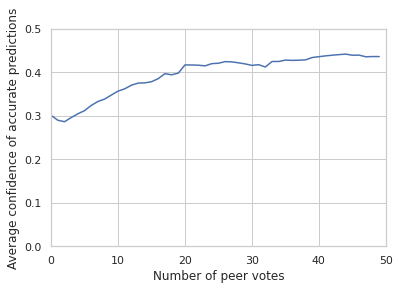

In [24]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns
from matplotlib import pyplot as plt
peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:xlim]
debug("Avg acc confidence")
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Avg acc confidence')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.0, 0.5])
plt.xlabel("Number of peer votes")
plt.ylabel("Average confidence of accurate predictions")
ax.set_xlim([0, xlim])

(-0.01, 0.5)

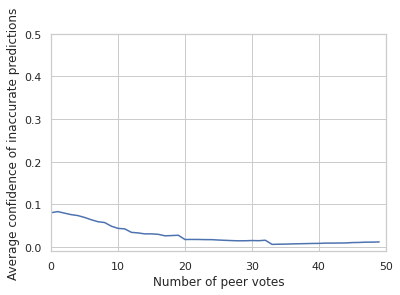

In [25]:
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Avg inacc confidence')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
plt.xlabel("Number of peer votes")
plt.ylabel("Average confidence of inaccurate predictions")
ax.set_xlim([0, xlim])
ax.set_ylim([-0.01, 0.5])

Text(0.5, 0, 'Number of peer votes')

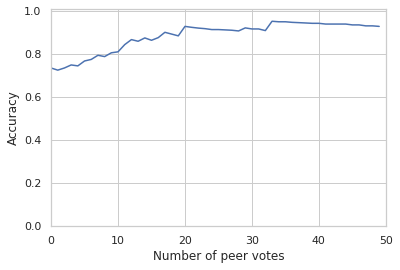

In [26]:
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Accuracy')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0, 1.01])
ax.set_xlim([0, xlim])
plt.xlabel("Number of peer votes")

------------------ 2022-09-03 06:56:13 ------------------
DEBUG: at <ipython-input-27-47671b891277>:1 <module>
Same as majority rate
------------------ 2022-09-03 06:56:13 ------------------


Text(0.5, 0, 'Number of peer votes')

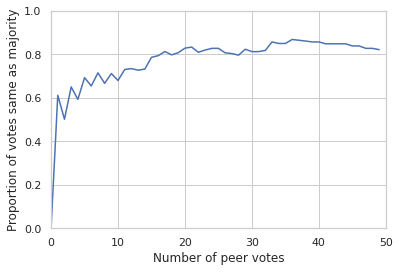

In [27]:
debug("Same as majority rate")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.0, 1.0])
ax.set_xlim([0, xlim])
ax.set_ylabel("Proportion of votes same as majority")
plt.xlabel("Number of peer votes")